In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow import keras
import matplotlib.pyplot as plt
import pathlib
import os
import pandas as pd
import numpy as np

In [2]:
Image_size = 256
Batch_size = 32

In [3]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='data/',
    labels='inferred',
    shuffle = True,
    batch_size=Batch_size,
    image_size=(Image_size, Image_size))


Found 2152 files belonging to 3 classes.


In [4]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
class_names = train_ds.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

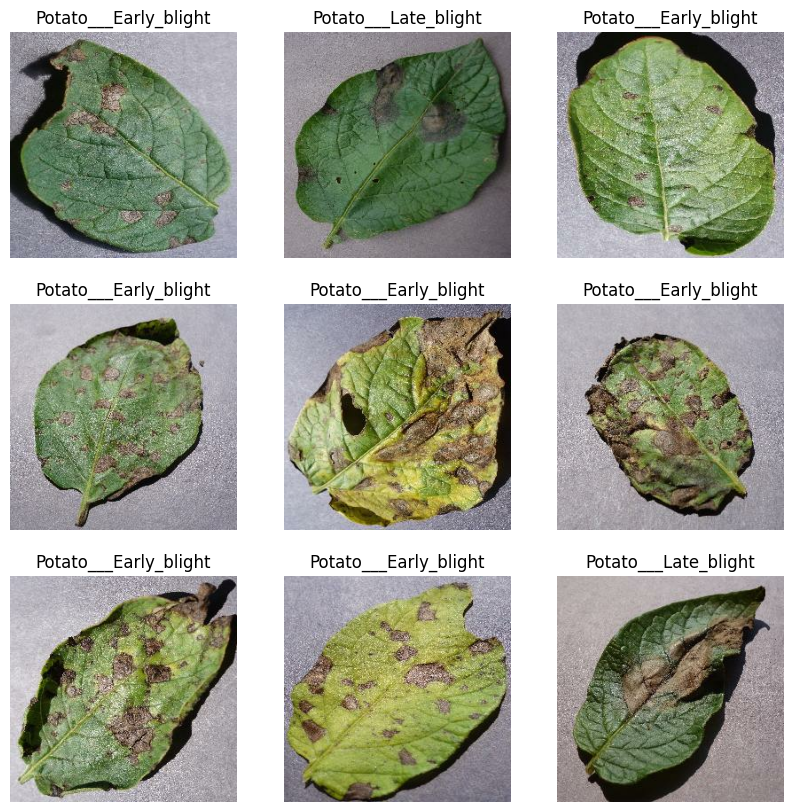

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [8]:
len(train_ds)

68

In [9]:
for imagebatch, labelbatch in train_ds.take(1):
    print(imagebatch.shape)
    print(labelbatch.numpy())

(32, 256, 256, 3)
[1 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 0 0 0]


In [10]:
for imagebatch, labelbatch in train_ds.take(1):
    print(imagebatch[0].numpy())

[[[159. 151. 162.]
  [161. 153. 164.]
  [162. 154. 165.]
  ...
  [116. 103. 112.]
  [104.  91. 100.]
  [135. 122. 131.]]

 [[161. 153. 164.]
  [159. 151. 162.]
  [157. 149. 160.]
  ...
  [125. 112. 121.]
  [107.  94. 103.]
  [115. 102. 111.]]

 [[163. 155. 166.]
  [157. 149. 160.]
  [151. 143. 154.]
  ...
  [ 99.  86.  95.]
  [ 99.  86.  95.]
  [110.  97. 106.]]

 ...

 [[154. 143. 149.]
  [152. 141. 147.]
  [150. 139. 145.]
  ...
  [ 96.  81.  88.]
  [ 97.  82.  89.]
  [ 91.  76.  83.]]

 [[159. 148. 154.]
  [156. 145. 151.]
  [154. 143. 149.]
  ...
  [ 90.  75.  82.]
  [ 96.  81.  88.]
  [ 99.  84.  91.]]

 [[158. 147. 153.]
  [155. 144. 150.]
  [153. 142. 148.]
  ...
  [118. 103. 110.]
  [112.  97. 104.]
  [ 89.  74.  81.]]]


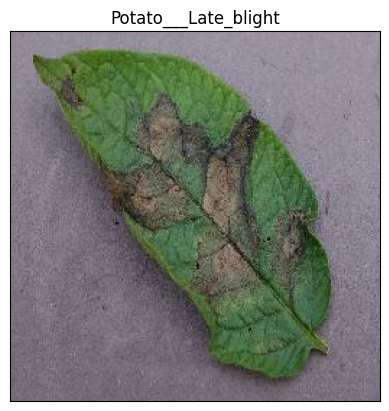

In [11]:
for imagebatch, labelbatch in train_ds.take(1):
    plt.imshow(imagebatch[0].numpy().astype("uint8"))
    plt.title(class_names[labelbatch[0]])
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()  # Display the plot


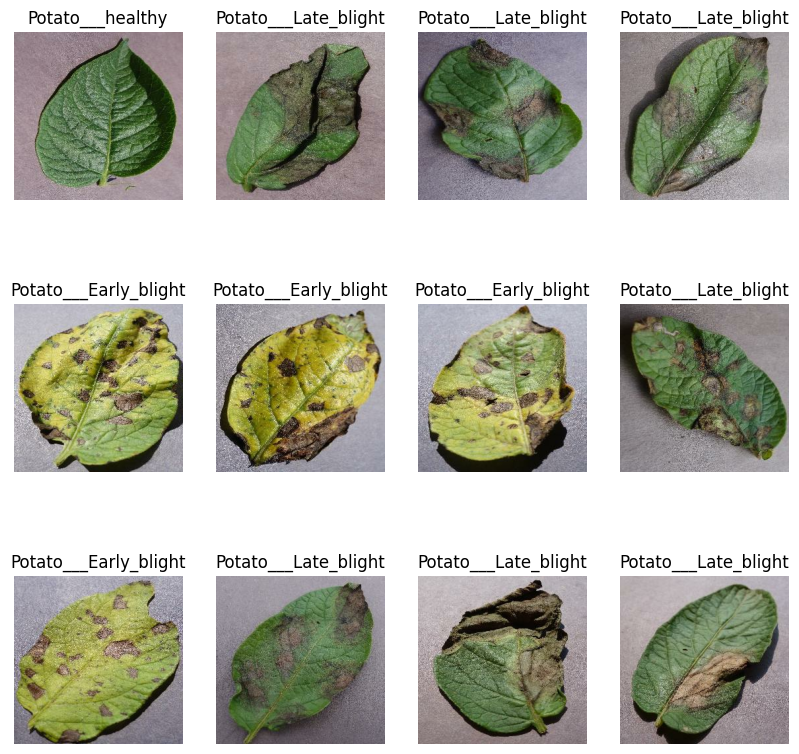

In [12]:
plt.figure(figsize=(10,10))
for imagebatch, labelbatch in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(imagebatch[i].numpy().astype("uint8"))
        plt.title(class_names[labelbatch[i]])
        ax.axis('off')

In [13]:
len(train_ds)

68

In [14]:
epochs = 30

In [15]:
int(len(train_ds)*.8)

54

In [16]:
train_dataset =  train_ds.take(int(len(train_ds)*.8))

In [17]:
len(train_dataset)

54

In [18]:
test_dataset =train_ds.skip(int(len(train_ds)*.8))

In [19]:
len(test_dataset)

14

In [20]:
int(len(train_ds)*.1)

6

In [21]:
validation_dataset = test_dataset.take(int(len(train_ds)*.1))
len(validation_dataset)

6

In [22]:
test_dataset=test_dataset.skip(int(len(train_ds)*.1))
len(test_dataset)

8

In [23]:
def get_data_split(dateset, 
                   train_split = 0.8, 
                   validation_split = 0.1,
                   test_split = 0.1,
                   shuffle = True, 
                   shuffle_size =10000):
    if shuffle:
        dateset = dateset.shuffle(shuffle_size, seed = 123)
    ds_size = len(dateset)
    train_size = int( ds_size * train_split)
    val_size = int(ds_size * validation_split)
    train_dataset =  dateset.take(train_size)    
    validation_dataset = dateset.take(val_size)
    test_dataset = dateset.skip(train_size).skip(val_size)
    return train_dataset, validation_dataset, test_dataset


In [24]:
train_ds, val_data, test_ds = get_data_split(train_ds)

In [25]:
len(train_ds)

54

In [26]:
len(val_data)

6

In [27]:
len(test_ds)

8

In [28]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:

resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_size,Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])


In [30]:
data_augmantation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [41]:
Channels = 3
classes = 3
input_shape = (Batch_size, Image_size, Image_size, Channels)
model = models.Sequential([
    resize_rescale,
    data_augmantation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(classes, activation='softmax'),
    
])
model.build(input_shape = input_shape)
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_43 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_43 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_44 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_44 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [40]:
Channels = 3
classes = 3
input_shape = (Batch_size, Image_size, Image_size, Channels)
model2 = models.Sequential([
    resize_rescale,
    data_augmantation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(classes, activation='softmax'),
    
])
model.build(input_shape = input_shape)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_31 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_31 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_32 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [42]:
model.compile(
optimizer='adam',
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics = ['accuracy']
)

In [43]:
histopy = model.fit(
    train_ds,
    epochs= epochs,
    batch_size=Batch_size,
    verbose=1,
    validation_data=val_data

)

Epoch 1/30
54/54 [==============================] - 91s 2s/step - loss: 0.8690 - accuracy: 0.5018 - val_loss: 0.6114 - val_accuracy: 0.7344
Epoch 2/30
54/54 [==============================] - 84s 2s/step - loss: 0.6140 - accuracy: 0.7001 - val_loss: 0.5604 - val_accuracy: 0.7344
Epoch 3/30
54/54 [==============================] - 90s 2s/step - loss: 0.5055 - accuracy: 0.7764 - val_loss: 0.3328 - val_accuracy: 0.8594
Epoch 4/30
54/54 [==============================] - 91s 2s/step - loss: 0.3752 - accuracy: 0.8404 - val_loss: 0.2728 - val_accuracy: 0.9010
Epoch 5/30
54/54 [==============================] - 79s 1s/step - loss: 0.2880 - accuracy: 0.8879 - val_loss: 0.2189 - val_accuracy: 0.9167
Epoch 6/30
54/54 [==============================] - 76s 1s/step - loss: 0.2200 - accuracy: 0.9085 - val_loss: 0.2254 - val_accuracy: 0.9167
Epoch 7/30
54/54 [==============================] - 76s 1s/step - loss: 0.1977 - accuracy: 0.9190 - val_loss: 0.2161 - val_accuracy: 0.9115
Epoch 8/30
54/54 [==

In [44]:
score1 = model.evaluate(test_ds)

8/8 [==============================] - 4s 277ms/step - loss: 0.0459 - accuracy: 0.9766


In [45]:
score1

[0.04587286710739136, 0.9765625]

In [47]:
histopy

In [49]:
histopy.params

{'verbose': 1, 'epochs': 30, 'steps': 54}

In [51]:
histopy.history['accuracy']

[0.5017605423927307,
 0.7001173496246338,
 0.7764084339141846,
 0.8403756022453308,
 0.887910783290863,
 0.908450722694397,
 0.9190140962600708,
 0.9196009635925293,
 0.9160798192024231,
 0.9419013857841492,
 0.9495305418968201,
 0.9542253613471985,
 0.9595070481300354,
 0.9501173496246338,
 0.9747652411460876,
 0.9794601202011108,
 0.9823943376541138,
 0.9642018675804138,
 0.9489436745643616,
 0.9753521084785461,
 0.9888497591018677,
 0.9853286147117615,
 0.9835680723190308,
 0.9794601202011108,
 0.9929577708244324,
 0.9929577708244324,
 0.98591548204422,
 0.9865023493766785,
 0.9929577708244324,
 0.9741784334182739]

In [52]:
histopy.history['val_accuracy']

[0.734375,
 0.734375,
 0.859375,
 0.9010416865348816,
 0.9166666865348816,
 0.9166666865348816,
 0.9114583134651184,
 0.953125,
 0.953125,
 0.921875,
 0.9166666865348816,
 0.953125,
 0.9635416865348816,
 0.9791666865348816,
 0.9739583134651184,
 0.9947916865348816,
 0.984375,
 0.9947916865348816,
 0.9270833134651184,
 0.9375,
 0.984375,
 0.9791666865348816,
 0.9322916865348816,
 0.9739583134651184,
 0.9635416865348816,
 0.9635416865348816,
 0.875,
 0.984375,
 0.9947916865348816,
 0.984375]

In [53]:
histopy.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [54]:
acc = histopy.history['accuracy']
val_acc = histopy.history['val_accuracy']

loss = histopy.history['loss']
val_loss = histopy.history['val_loss']

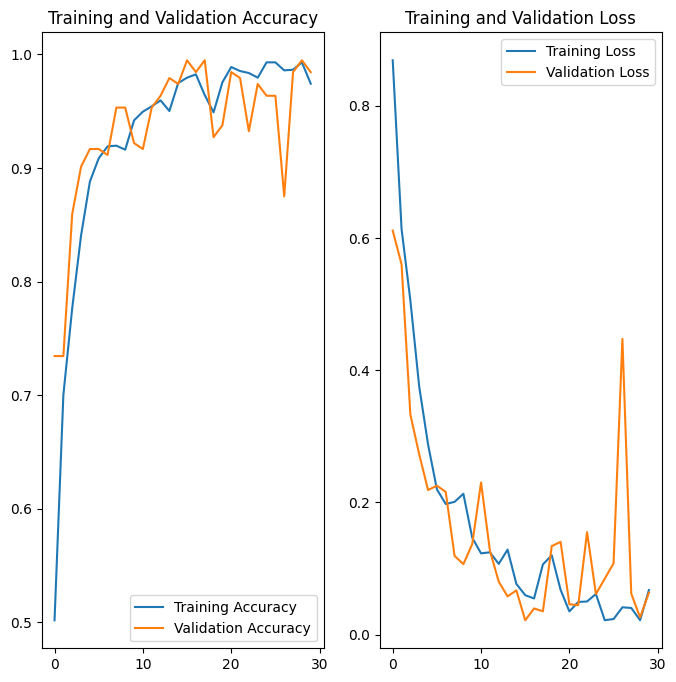

In [57]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [58]:
model2.compile(
optimizer='adam',
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics = ['accuracy']
)

In [59]:
histopy2 = model2.fit(
    train_ds,
    epochs= epochs,
    batch_size=Batch_size,
    verbose=1,
    validation_data=val_data

)

Epoch 1/30
54/54 [==============================] - 80s 1s/step - loss: 0.8822 - accuracy: 0.4806 - val_loss: 0.7339 - val_accuracy: 0.6198
Epoch 2/30
54/54 [==============================] - 75s 1s/step - loss: 0.7109 - accuracy: 0.6367 - val_loss: 0.5463 - val_accuracy: 0.7188
Epoch 3/30
54/54 [==============================] - 75s 1s/step - loss: 0.4947 - accuracy: 0.7723 - val_loss: 0.2252 - val_accuracy: 0.9062
Epoch 4/30
54/54 [==============================] - 76s 1s/step - loss: 0.2592 - accuracy: 0.8961 - val_loss: 0.2295 - val_accuracy: 0.9219
Epoch 5/30
54/54 [==============================] - 78s 1s/step - loss: 0.2225 - accuracy: 0.9202 - val_loss: 0.1701 - val_accuracy: 0.9375
Epoch 6/30
54/54 [==============================] - 75s 1s/step - loss: 0.2422 - accuracy: 0.9020 - val_loss: 0.1507 - val_accuracy: 0.9375
Epoch 7/30
54/54 [==============================] - 75s 1s/step - loss: 0.1874 - accuracy: 0.9249 - val_loss: 0.1291 - val_accuracy: 0.9427
Epoch 8/30
54/54 [==

In [60]:
score2 = model2.evaluate(test_ds)

8/8 [==============================] - 3s 363ms/step - loss: 0.0521 - accuracy: 0.9766


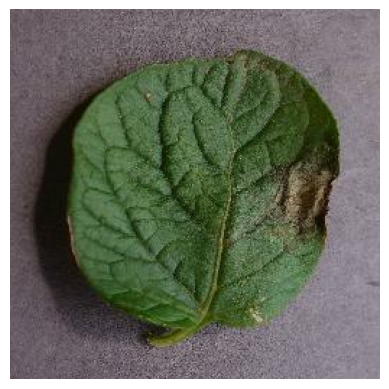

In [68]:
for imagebatch, labelbatch in test_ds.take(1):
    plt.imshow(imagebatch[0].numpy().astype('uint8'))
    plt.axis('off')

image label Potato___Early_blight
1/1 [==============================] - 0s 268ms/step
[9.9993694e-01 6.3027466e-05 7.2669443e-14]
99.99369382858276
Potato___Early_blight


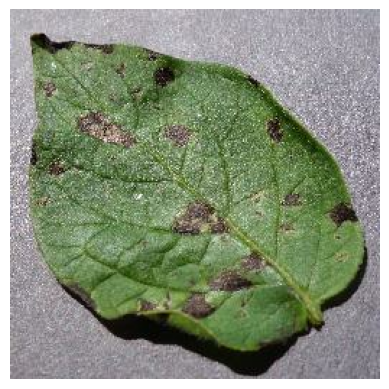

In [94]:
for imagebatch, labelbatch in test_ds.take(1):
    first_image = (imagebatch[0].numpy().astype('uint8'))
    first_label = labelbatch[0].numpy().astype('uint8')
    print("image label",class_names[first_label])
    
    
    plt.imshow(first_image)
    batch_pre = model.predict(imagebatch)
    print(batch_pre[0])
    print(batch_pre[0][0]*100)
    print(class_names[np.argmax(batch_pre[0])])
    plt.axis('off')

In [ ]:
def predict_function(model, image):
    

In [103]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 27ms/step


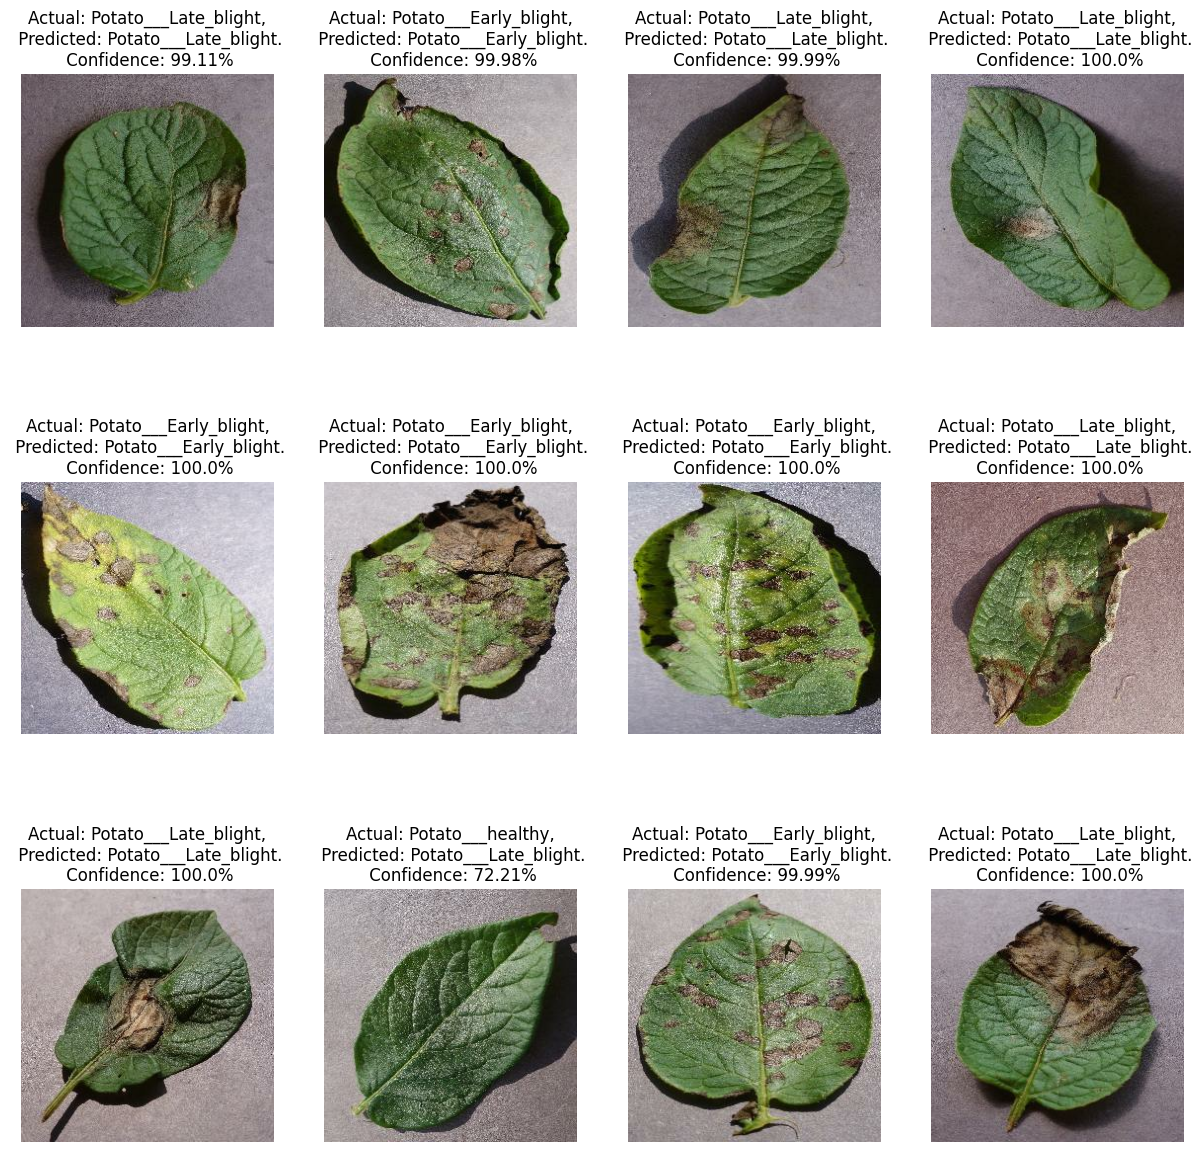

In [110]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

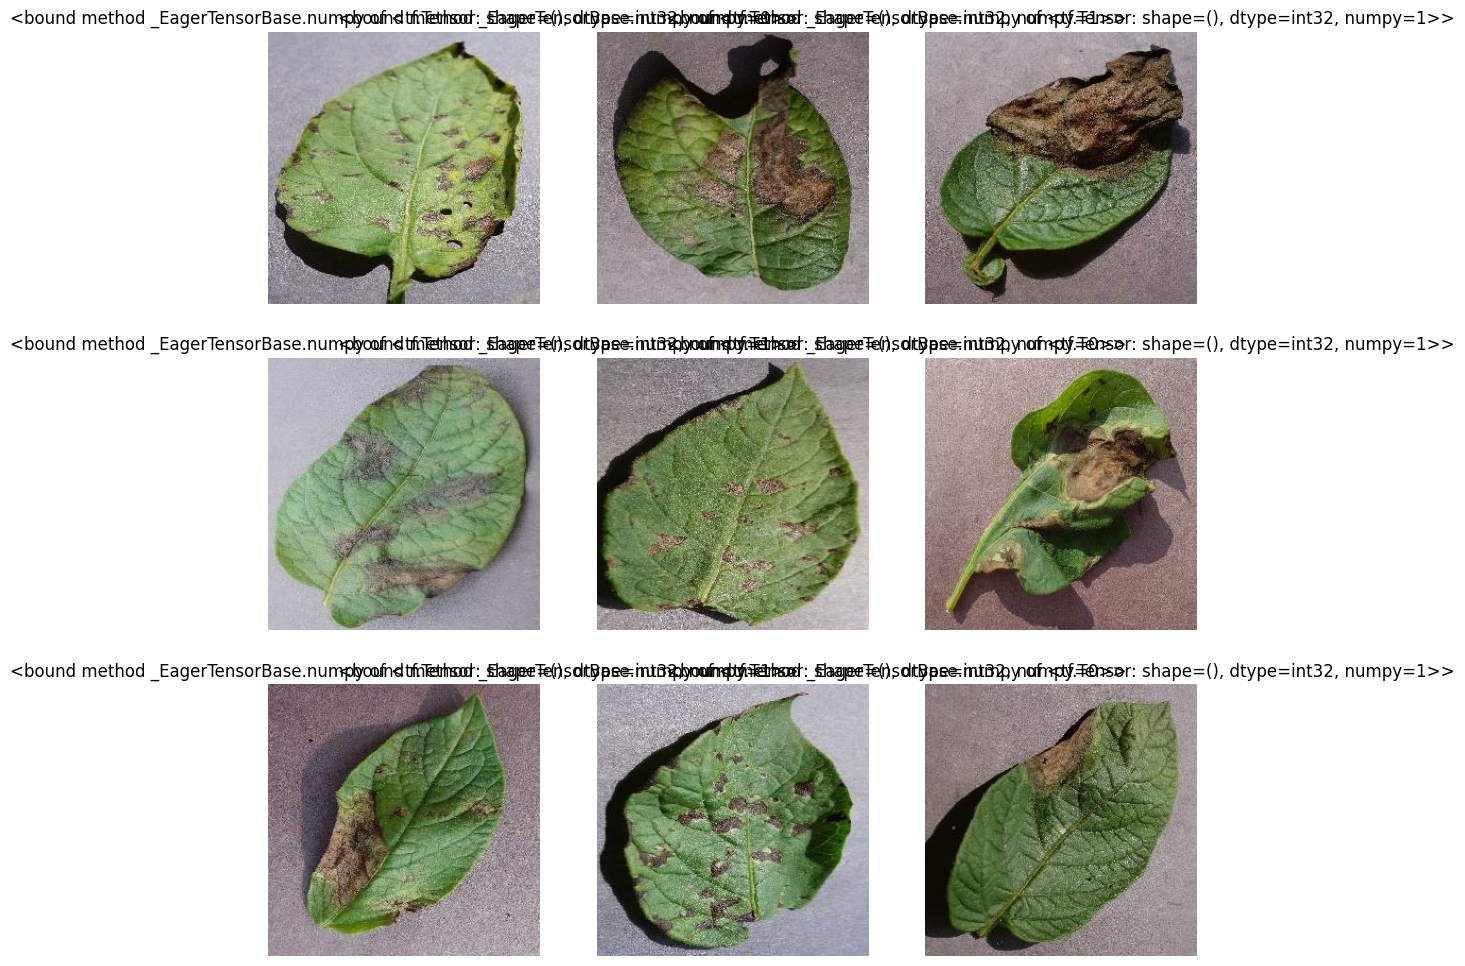

In [102]:
plt.figure(figsize=(12,12))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(labels[i].numpy)
        plt.axis('off')
        

In [129]:
model_version = 1

model.save(f"model/{model_version}")

INFO:tensorflow:Assets written to: model/1\assets


INFO:tensorflow:Assets written to: model/1\assets


In [130]:
import os
os.listdir("model/")

['1', '1.0', '2']

In [132]:
import os
[int(i) for i in os.listdir("model/")]

[1, 2]

In [134]:
max([int(i) for i in os.listdir("model/")])

2

In [136]:
# auto model version update
model_version = max([int(i) for i in os.listdir("model/")]) + 1

model.save(f"model/{model_version}")

INFO:tensorflow:Assets written to: model/4\assets


INFO:tensorflow:Assets written to: model/4\assets


In [137]:
#check total model version
[int(i) for i in os.listdir("model/")]

[1, 2, 3, 4]